# Braille detection with CNN

In this script we create, train and evaluate an image classifier based on convolutional networks.

In [98]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
from torch.utils.data import Dataset, DataLoader
import fnmatch
from skimage import io, transform
import torchvision
import pandas as pd

# Define the device and data repository
device = 'cpu'
data_dir = 'dataset/'

# Data management

We read data, split it onto train, val and test and create data loaders with preprocessing.

In [22]:
# We start by creating a class object for representing our image data
# This is a subclass of torch.utils.data.dataset.Dataset that will serve as input to the DataLoader

class ImageDataset(Dataset):

    def __init__(self, image_dir, transform=None):
        """Here we initialize the attributes of the object of the class."""
        self.image_dir = image_dir
        self.image_files = sorted(self._find_files(image_dir))
        self.classes = [filename.split("/")[-1][0] for filename in self.image_files]
        self.let2num = {a: i for i, a in enumerate(sorted(list(set(self.classes))))}
        self.num2let = {i: a for a, i in self.let2num.items()}
        
        self.transform = transform
        
    def letter_to_number(self, let):
        return self.let2num[let]
    
    def number_to_letter(self, num):
        return self.num2let[num]
    

    def __len__(self):
        """Here we return the size of the dataset."""
        return len(self.image_files)

    def __getitem__(self, index):
        """Here we return a data sample for a given index."""
        # TO DO: write this function: it takes as input 'index' (which is an integer number),
        # and returns the corresponding item as a pytorch tensor
        # hint: use 'self.image_files' , which is the list of images paths defined in the '__init__' method
        filename = self.image_files[index]
        x = io.imread(filename)
        
        if self.transform:
            x = self.transform(x)
        
        return x, self.classes[index]

    def _find_files(self, directory, pattern='*.jpg'):
        """Recursively finds all files matching the pattern."""
        files = []
        for root, dirnames, filenames in os.walk(directory):
            for filename in fnmatch.filter(filenames, pattern):
                files.append(os.path.join(root, filename))
        return files


In [23]:
#to divide: torch.utils.data.random_split(dataset, lengths)
data_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize(
                                                      mean=(0.5, 0.5, 0.5), 
                                                      std=(0.3,0.3,0.3))])

In [24]:
dataset = ImageDataset(image_dir=data_dir, transform=data_transforms)

In [25]:
len(set(dataset.classes))

26

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


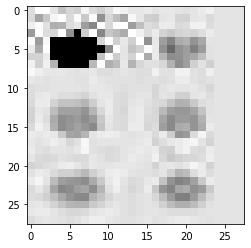

In [26]:
plt.imshow(dataset[0][0].numpy().transpose(1, 2, 0))

In [27]:
dataset[0][0].size()

torch.Size([3, 28, 28])

In [28]:
dataset.letter_to_number(dataset[0][1])

0

In [29]:
dataset.number_to_letter(0)

'a'

In [30]:
dataset_ln = len(dataset)
train_ln, val_ln, test_ln = int(dataset_ln * 0.8), int(dataset_ln * 0.1), int(dataset_ln * 0.1)

In [31]:
train_data, val_data, test_data = torch.utils.data.random_split(dataset, [train_ln, val_ln, test_ln], generator=torch.Generator().manual_seed(42))

In [32]:
len(val_data)

156

In [33]:
val_data[1]

(tensor([[[1.6667, 1.6667, 1.6536,  ..., 1.6013, 1.6275, 1.6536],
          [1.6667, 1.6667, 1.6536,  ..., 1.6013, 1.6275, 1.6536],
          [1.6667, 1.6667, 1.6536,  ..., 1.6013, 1.6275, 1.6536],
          ...,
          [1.6536, 1.6536, 1.6536,  ..., 1.6405, 1.6405, 1.6536],
          [1.6536, 1.6536, 1.6536,  ..., 1.6405, 1.6405, 1.6536],
          [1.6536, 1.6536, 1.6536,  ..., 1.6405, 1.6405, 1.6536]],
 
         [[1.6667, 1.6667, 1.6536,  ..., 1.6013, 1.6275, 1.6536],
          [1.6667, 1.6667, 1.6536,  ..., 1.6013, 1.6275, 1.6536],
          [1.6667, 1.6667, 1.6536,  ..., 1.6013, 1.6275, 1.6536],
          ...,
          [1.6536, 1.6536, 1.6536,  ..., 1.6405, 1.6405, 1.6536],
          [1.6536, 1.6536, 1.6536,  ..., 1.6405, 1.6405, 1.6536],
          [1.6536, 1.6536, 1.6536,  ..., 1.6405, 1.6405, 1.6536]],
 
         [[1.6667, 1.6667, 1.6536,  ..., 1.6013, 1.6275, 1.6536],
          [1.6667, 1.6667, 1.6536,  ..., 1.6013, 1.6275, 1.6536],
          [1.6667, 1.6667, 1.6536,  ...,

In [34]:
def collate_fn(data):
    images, labels = zip(*data)
    
    labels = [dataset.letter_to_number(label) for label in labels]
    return torch.stack(images).float(), torch.tensor(labels).long()


In [35]:
batch_size = 8
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size, collate_fn=collate_fn)
val_dataloader = DataLoader(val_data, batch_size=batch_size, collate_fn=collate_fn)
test_dataloader = DataLoader(test_data, batch_size=batch_size, collate_fn=collate_fn)


# Model

Here we create several different models to compare


In [36]:
# Define a CNN classifier module.

class CNNSimpleClassif(nn.Module):
    def __init__(self, num_channels1=16, num_channels2=32, num_classes=26):
        super(CNNSimpleClassif, self).__init__()
        

        self.l1 = nn.Sequential(nn.Conv2d(3, num_channels1, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.BatchNorm2d(16),
                           nn.MaxPool2d(kernel_size=2))
        self.l2 = nn.Sequential(nn.Conv2d(num_channels1, num_channels2, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.BatchNorm2d(32),
                           nn.MaxPool2d(kernel_size=2))
        
        size_vec = 1568
        self.res = nn.Linear(size_vec, num_classes)
    def forward(self, x):
        x = self.l2(self.l1(x))
        x = x.reshape(x.shape[0], -1)
        out = self.res(x)
        return out

In [42]:
# Define a CNN classifier module.

class CNNSimple6Cells(nn.Module):
    def __init__(self, num_channels1=16, num_channels2=32, num_classes=26):
        super(CNNSimple6Cells, self).__init__()
        

        self.l1 = nn.Sequential(nn.Conv2d(3, num_channels1, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.BatchNorm2d(16),
                           nn.MaxPool2d(kernel_size=2))
        self.l2 = nn.Sequential(nn.Conv2d(num_channels1, num_channels2, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.BatchNorm2d(32),
                           nn.MaxPool2d(kernel_size=2))
        
        size_vec = 1568
        self.lin6 = nn.Sequential(nn.Linear(size_vec, 6), nn.ReLU())
        self.res = nn.Sequential(nn.Linear(6, 100),
                                 nn.ReLU(),
                                 nn.Linear(100, num_classes))
    def forward(self, x):
        x = self.l2(self.l1(x))
        x = x.reshape(x.shape[0], -1)
        out = self.res(self.lin6(x))
        return out

In [51]:
braille_map = {"a":"100000", "b":"110000", "c":"100100", "d":"100110", "e":"100010",
               "f":"110100", "g":"110110", "h":"110010", "i":"010100", "j":"101000",
               "k":"111000", "l":"101100", "m":"101110", "n":"101110", "o":"101010",
               "p":"111100", "q":"111110", "r":"111010", "s":"011100", "t":"011110",
               "u":"101001", "v":"111001", "w":"010111", "x":"101101", "y":"101111",
               "z":"101011"}

In [53]:
braille_map_rev = {v:k for k, v in braille_map.items()}

In [79]:
# Define a CNN classifier module.

class CNNSimple6CellsMap(nn.Module):
    def __init__(self, num_channels1=16, num_channels2=32):
        super(CNNSimple6CellsMap, self).__init__()
        

        self.l1 = nn.Sequential(nn.Conv2d(3, num_channels1, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.BatchNorm2d(16),
                           nn.MaxPool2d(kernel_size=2))
        self.l2 = nn.Sequential(nn.Conv2d(num_channels1, num_channels2, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.BatchNorm2d(32),
                           nn.MaxPool2d(kernel_size=2))
        
        size_vec = 1568
        self.res = nn.Linear(size_vec, 6)
        self.finact = nn.Sigmoid()
    def forward(self, x):
        x = self.l2(self.l1(x))
        x = x.reshape(x.shape[0], -1)
        out = self.finact(self.res(x))
        if self.training:
            return out
        else:
            res = []
            for t in out:
                key = "".join(map(lambda a: str(a.item()), torch.round(t).long()))
                if key not in braille_map_rev:
                    res.append(0)
                    continue
                res.append(dataset.letter_to_number(braille_map_rev[key]))
            res = nn.functional.one_hot(torch.tensor(res), num_classes=26)
            return res

# Useful functions for training, validation and testing

In [55]:
def eval_model(model, eval_dataloader, device='cpu'):

    # Copy the model to the device
    model.to(device)
    # Set the model in 'evaluation' mode (this disables some layers (batch norm, dropout...) which are not needed when testing)
    model.eval() 

    # In evaluation phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct_labels = 0
        total_labels = 0
        
        # Iterate over the dataset using the dataloader
        for images, labels in eval_dataloader:

            # Get the predicted labels classes
            images = images.to(device)
            labels = labels.to(device)
            y_predicted = model(images)
            
            # To get the predicted labels, we need to get the max over all possible classes
            _, label_predicted = torch.max(y_predicted.data, 1)
            
            # Compute accuracy: count the total number of samples, and the correct labels (compare the true and predicted labels)
            total_labels += labels.size(0)
            correct_labels += (label_predicted == labels).sum().item()
    
    accuracy = 100 * correct_labels / total_labels
    
    return accuracy

In [62]:
t = torch.tensor(5)

In [67]:
t.item()

5

In [88]:
def train_model(model, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate, 
                device='cpu', verbose=True, model_name='simple', optim='SGD', cells=False):

    # Copy the model to the device and set it in 'training' mode (thus all gradients are computed)
    model = model.to(device)
    model.train()
    
    # Define the optimizer
    if optim == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    elif optim == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Initialize a list to record the training loss over epochs
    loss_all_epochs = []
    
    last_best_acc = 0
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        # Initialize the training loss for the current epoch
        loss_current_epoch = 0
        
        # Iterate over batches using the dataloader
        for batch_index, (images, labels) in enumerate(train_dataloader):
            #print(labels)
            #print(images.size(), labels.size(), labels)
            images = images.to(device)
            if cells:
                new_labels = torch.zeros((len(labels), 6))
                for i, l in enumerate(labels):
                    new_labels[i] = torch.tensor(list(map(int, braille_map[dataset.number_to_letter(l.item())]))).float()
                labels = new_labels
            else:
                labels = labels.to(device)
            
            y_pred = model(images)
            loss = loss_fn(y_pred, labels)
            
            
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
            
            loss_current_epoch += loss.item()
            
        cur_acc = eval_model(model, valid_dataloader)
        if cur_acc > last_best_acc:
            last_best_acc = cur_acc
            torch.save(model.state_dict(), f'model_{model_name}_best.pt')
            print("\nNew best accuracy! ", last_best_acc)
            
        # At the end of each epoch, record and display the loss over all batches
        loss_all_epochs.append(loss_current_epoch)
        if verbose:
            print('\rEpoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss_current_epoch), end='')
        
    return model, loss_all_epochs

# Experiments

In [165]:
all_results = {"Model":[], "Loss":[], "Optmizer":[], "lr":[], "Accuracy":[]}

In [166]:
num_channels1 = 16
num_channels2 = 32
num_classes = 26
model = CNNSimpleClassif(num_channels1, num_channels2, num_classes)


New best accuracy!  44.87179487179487
Epoch [1/20], Loss: 414.2008
New best accuracy!  55.76923076923077
Epoch [2/20], Loss: 258.4689
New best accuracy!  64.1025641025641
Epoch [3/20], Loss: 203.4402
New best accuracy!  64.74358974358974
Epoch [4/20], Loss: 170.9858
New best accuracy!  69.23076923076923
Epoch [6/20], Loss: 129.8243
New best accuracy!  71.7948717948718
Epoch [8/20], Loss: 103.8550
New best accuracy!  74.35897435897436
Epoch [11/20], Loss: 70.9860
New best accuracy!  76.28205128205128
Epoch [12/20], Loss: 63.8536
New best accuracy!  76.92307692307692
Epoch [13/20], Loss: 55.5470
New best accuracy!  78.84615384615384
Epoch [17/20], Loss: 34.3854
New best accuracy!  79.48717948717949
Epoch [18/20], Loss: 30.5221
New best accuracy!  80.12820512820512
Epoch [20/20], Loss: 24.6304

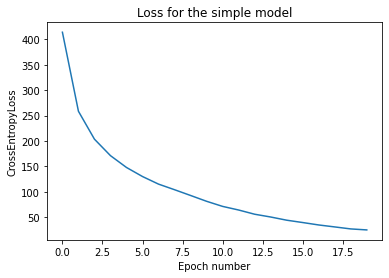

In [167]:
# Optimizer
num_epochs = 20
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.001

# Training
model, loss_total = train_model(model, train_dataloader, val_dataloader, num_epochs, loss_fn, learning_rate, device='cpu', verbose=True)

# Save the model and display the loss over epochs
torch.save(model.state_dict(), 'model_simple.pt')
plt.plot(loss_total)



plt.title("Loss for the simple model")
plt.xlabel("Epoch number")
plt.ylabel("CrossEntropyLoss")
plt.savefig("plots/model_simple_loss.png")
plt.show() 

In [168]:
model = CNNSimpleClassif(num_channels1, num_channels2, num_classes)

model.load_state_dict(torch.load('model_simple_best.pt'))

res = eval_model(model, test_dataloader, device='cpu')
print(res)

78.2051282051282


In [169]:
all_results["Model"].append("simple")
all_results["Loss"].append("CrossEntropyLoss")
all_results["Optmizer"].append("SGD")
all_results["lr"].append(learning_rate)
all_results["Accuracy"].append(res)


New best accuracy!  22.435897435897434
Epoch [1/40], Loss: 463.8907
New best accuracy!  36.53846153846154
Epoch [2/40], Loss: 329.7652
New best accuracy!  40.38461538461539
Epoch [3/40], Loss: 250.8624
New best accuracy!  52.56410256410256
Epoch [5/40], Loss: 197.7638
New best accuracy!  60.256410256410255
Epoch [6/40], Loss: 169.7926
New best accuracy!  64.74358974358974
Epoch [10/40], Loss: 124.4526
New best accuracy!  65.38461538461539
Epoch [11/40], Loss: 119.6243
New best accuracy!  72.43589743589743
Epoch [14/40], Loss: 94.87765
New best accuracy!  73.71794871794872
Epoch [16/40], Loss: 74.2865
New best accuracy!  78.2051282051282
Epoch [19/40], Loss: 71.6347
New best accuracy!  79.48717948717949
Epoch [24/40], Loss: 54.2068
New best accuracy!  80.12820512820512
Epoch [25/40], Loss: 41.3348
New best accuracy!  80.76923076923077
Epoch [28/40], Loss: 44.5847
New best accuracy!  82.05128205128206
Epoch [34/40], Loss: 58.2368
New best accuracy!  83.97435897435898
Epoch [35/40], Loss

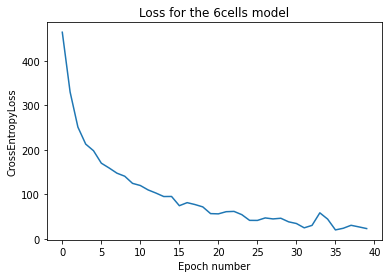

In [170]:
num_channels1 = 16
num_channels2 = 32
num_classes = 26
model = CNNSimple6Cells(num_channels1, num_channels2, num_classes)

# Optimizer
num_epochs = 40
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.003

# Training
model, loss_total = train_model(model, train_dataloader, val_dataloader, num_epochs, loss_fn, learning_rate, device='cpu', verbose=True, model_name="6cells", optim='Adam')

# Save the model and display the loss over epochs
torch.save(model.state_dict(), 'model_simple_6_cells.pt')
plt.plot(loss_total)

plt.title("Loss for the 6cells model")
plt.xlabel("Epoch number")
plt.ylabel("CrossEntropyLoss")
plt.savefig("plots/model_simple_6cells_loss.png") 
plt.show()


In [171]:
model = CNNSimple6Cells(num_channels1, num_channels2, num_classes)

model.load_state_dict(torch.load('model_6cells_best.pt'))

res = eval_model(model, test_dataloader, device='cpu')
print(res)

89.74358974358974


In [172]:
all_results["Model"].append("6cells")
all_results["Loss"].append("CrossEntropyLoss")
all_results["Optmizer"].append("Adam")
all_results["lr"].append(learning_rate)
all_results["Accuracy"].append(res)


New best accuracy!  45.51282051282051
Epoch [1/40], Loss: 61.2103
New best accuracy!  51.92307692307692
Epoch [2/40], Loss: 43.7521
New best accuracy!  60.256410256410255
Epoch [3/40], Loss: 36.2430
New best accuracy!  63.46153846153846
Epoch [4/40], Loss: 30.6033
New best accuracy!  65.38461538461539
Epoch [5/40], Loss: 26.2512
New best accuracy!  67.3076923076923
Epoch [7/40], Loss: 19.6476
New best accuracy!  69.23076923076923
Epoch [10/40], Loss: 12.8342
New best accuracy!  75.0
Epoch [12/40], Loss: 9.53911
New best accuracy!  75.64102564102564
Epoch [14/40], Loss: 7.2286
New best accuracy!  76.28205128205128
Epoch [23/40], Loss: 2.4421
New best accuracy!  77.56410256410257
Epoch [27/40], Loss: 1.7131
New best accuracy!  78.2051282051282
Epoch [31/40], Loss: 1.2332
New best accuracy!  78.84615384615384
Epoch [40/40], Loss: 0.7952

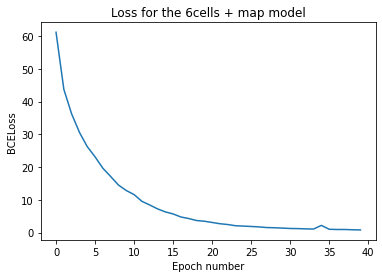

In [173]:
num_channels1 = 16
num_channels2 = 32
num_classes = 26
model = CNNSimple6CellsMap(num_channels1, num_channels2)

# Optimizer
num_epochs = 40
loss_fn = nn.BCELoss()
learning_rate = 0.01

# Training
model, loss_total = train_model(model, train_dataloader, val_dataloader, num_epochs, loss_fn, learning_rate, device='cpu', verbose=True, model_name="6cells_map", optim='SGD', cells=True)

# Save the model and display the loss over epochs
torch.save(model.state_dict(), 'model_6_cells_map.pt')

plt.title("Loss for the 6cells + map model")
plt.xlabel("Epoch number")
plt.ylabel("BCELoss")

plt.plot(loss_total)
plt.savefig("plots/model_simple_6cells_map_loss.png") 
plt.show()

In [174]:
model = CNNSimple6CellsMap(num_channels1, num_channels2)

model.load_state_dict(torch.load('model_6cells_map_best.pt'))

res = eval_model(model, test_dataloader, device='cpu')
print(res)

75.0


In [175]:
all_results["Model"].append("6cells_map")
all_results["Loss"].append("BCELoss")
all_results["Optmizer"].append("SGD")
all_results["lr"].append(learning_rate)
all_results["Accuracy"].append(res)

In [176]:
df_results = pd.DataFrame(all_results)

In [177]:
df_results.to_csv("evaluation_results.csv")

In [178]:
df_results

,Model,Loss,Optmizer,lr,Accuracy
0,simple,CrossEntropyLoss,SGD,0.001,78.205128
1,6cells,CrossEntropyLoss,Adam,0.003,89.743590
2,6cells_map,BCELoss,SGD,0.010,75.000000


In [179]:
pd.read_csv("evaluation_results.csv", index_col=0)

,Model,Loss,Optmizer,lr,Accuracy
0,simple,CrossEntropyLoss,SGD,0.001,78.205128
1,6cells,CrossEntropyLoss,Adam,0.003,89.743590
2,6cells_map,BCELoss,SGD,0.010,75.000000
